In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import elasticsearch
from elasticsearch import helpers
import time
import datetime

# PROCESS REACTOME (TOP-LEVEL) PATHWAY FILES

## IMPORT ALL NEEDED FILES

In [2]:
# Get all gene_set_pathway files 
dir_path = os.getcwd()
tmp = os.listdir(dir_path + "/gene_set_data")
input_files = [ dir_path + "/gene_set_data/" + file_name for file_name in tmp ]

In [3]:
# Create df that stores the relationship between pathway ID and pathway name
pathways_names_path = os.getcwd() + "/Reactome_TopLevel_Pathways.tsv"
pathways_names = pd.read_csv(pathways_names_path, sep="\t", header = 0)

In [4]:
# Reformat pathway IDs and store pairs in a dictionary
pathways_names.id = pathways_names.id.apply(lambda x: x.split(".")[0])
pathways_dict = dict(pathways_names.to_dict('split')['data'])

The follwoing step processes each one of the input files and gives them an appropriate formatting.<br>
In addition, the information is stored in a single dataframe.

In [5]:
# Read each gene_set file and store genes in a df where each column represents a single top-level pathway
# with their corresponding genes
toplevel = pd.DataFrame()

for file in input_files:    
    pathway = pathways_dict[file.split("/")[-1].split("_")[-1]]
    df = pd.read_csv(file, sep="\n", header=None)
    df = df[0].str.split("\t", expand=True).transpose()
    df.columns = df.iloc[0]
    df.drop([0,1], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    gene_set = set()
    for colname in df:
        gene_set.update(list(df[colname][~df[colname].isnull()])) 
    
    tmp_df = pd.DataFrame()  
    tmp_df[pathway] = list(gene_set)
    toplevel = pd.concat([tmp_df, toplevel], axis=1)

In [6]:
toplevel.head()

,Protein localization,Circadian Clock,DNA Replication,Metabolism of proteins,Organelle biogenesis and maintenance,Extracellular matrix organization,Signal Transduction,Developmental Biology,Hemostasis,Chromatin organization,...,Cell Cycle,Disease,Reproduction,Gene expression (Transcription),DNA Repair,Sensory Perception,Immune System,Digestion and absorption,Metabolism,Programmed Cell Death
0,MPV17,BHLHE41,H2BC3,ASGR2,TUBA1A,MMP17,MAP2K2,MAP2K2,GP9,H2BC3,...,CHMP4B,MAP2K2,H2BC3,KMT2A,ACTR8,AKR1C4,fljB,MGAM,AKR1C4,CD14
1,COA6,HDAC3,H2BC1,TTLL9,CHCHD6,CTRB2,IKZF1,DSP,ATP1B2,H2BC1,...,TUBA4A,TBL1XR1,H2BC1,SMYD2,MPG,OR4D11,RPS6KA1,LIPF,TYR,DSP
2,PEX6,EP300,MCM8,TUBA4A,DYNC1I2,COL5A1,FGD1,KMT2A,SLC8A3,KDM4D,...,SYCP1,ADAMTSL4,H3C1,ZNF347,STRA13,OR4K14,CEACAM1,AMY1C,TBL1XR1,MC159L
3,AGPS,TBL1XR1,H3C1,ADAMTSL4,TBL1XR1,CEACAM1,TBL1XR1,NFKB1,FAM3C,KMT2A,...,PSMD3,CTNNB1,CATSPER3,TBL1XR1,NEIL2,OR52J3,CTNNB1,ALPI,DHFR2,OPA1
4,PXMP2,CCRN4L,ANAPC4,CTNNB1,TCP1,TNN,ARHGAP35,TBL1XR1,MANF,PRMT3,...,PSMD5,SPRED2,ADAM2,CTNNB1,SUMO2,TAS2R10,PTPN9,GUCA2B,PSMB11,CASP4


The following code defines a function which will perform the connection with the ES database to retrieve all the queried information about the presence or absence of the genes.

In [ ]:
# Function that looks up each gene in ES
def query_geneSymbol(gene_symbol, index_name="dgnplus_gene_v19"):
    resp = helpers.scan(
        elasticsearch.Elasticsearch([{'host': '', 'port': 3307}]),
        index=index_name,
        scroll='8m',
        size=1000,
        query={
            "_source": ["symbol_keyword", "geneID"], # fields we want to retrieve
            "query": {
                "term": {"symbol_keyword": {"value": gene_symbol}} # PMID to search for
            }
        }
    )
    if resp:
        return resp
    else:
        return None

Here we do the hard work, this code may take several minutes to run because in fact is looking for all the genes from the Reactome files in ES. In the case a gene is found, it adds +1 to a counter and when it finishes with that pathway it adds a row to a new Dataframe which will store all top-level pathways from <i>Homo sapiens</i> in Reactome and all the gene counts (genes found in ES).

In [183]:
starttime = time.time()
genes_in_dgnplus = pd.DataFrame(columns=["name", "count"])

print("Querying ES for all genes coming from Reactome... This may around 5 minutes")
for colname in toplevel:
    gene_set = set()
    gene_set.update(list(toplevel[colname][~toplevel[colname].isnull()]))
    
    counter = 0
    gene_set = list(gene_set)
    for gene in gene_set:
        for response in query_geneSymbol(gene):
            if "_source" in response.keys() and "symbol_keyword" in response["_source"].keys():
                counter += 1
    new_row = pd.Series({"name":colname, "count":counter})
    genes_in_dgnplus = pd.concat([genes_in_dgnplus, new_row.to_frame().T], ignore_index=True)

endtime = time.time()
print("ELAPSED TIME (hh:mm:ss): {}".format(datetime.timedelta(seconds=(endtime-starttime))))

Querying ES for all genes coming from Reactome... This may around 5 minutes
ELAPSED TIME (hh:mm:ss): 0:04:31.936633


In [184]:
# Create small df from reactome data with pathway names and gene counts
counts_reactome = toplevel.count().reset_index()
counts_reactome.columns = ["name","count_reactome"]
counts_reactome.head()

,name,count_reactome
0,DNA Replication,157
1,Cell Cycle,662
2,Programmed Cell Death,212
3,Drug ADME,108
4,Chromatin organization,240


## BARPLOT OF GENE COUNTS FOR EACH REACTOME PATHWAY

Then, we create a grouped barplot in which for each Reactome pathway we plot both the gene counts as reported in Reactome and the ones retrieved from DGN+.

As it can be seen the values are almost always close to each other for each pathway, but never equal, meaning that not all genes from Reactome are stored in DGN+.

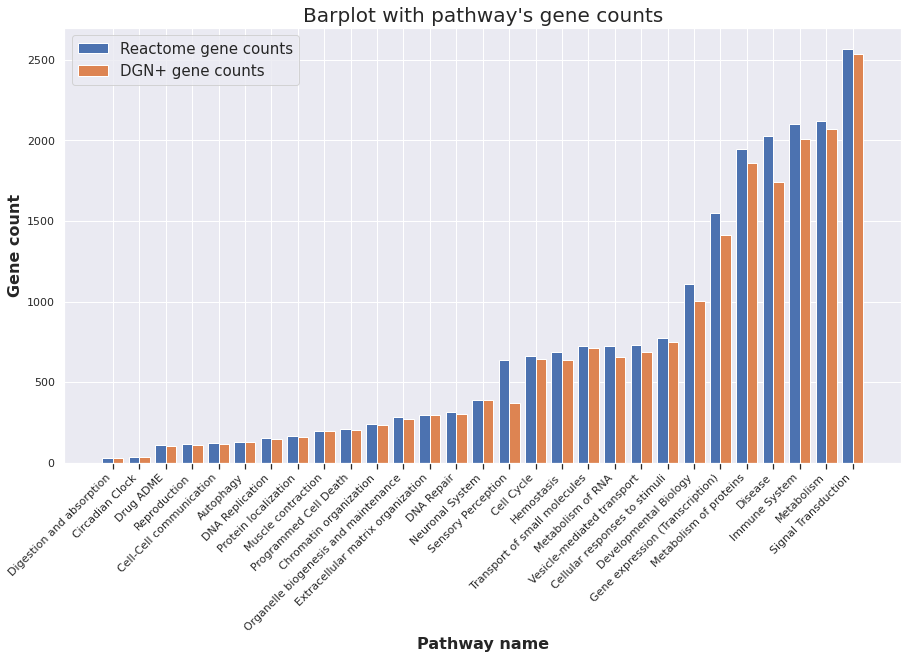

In [198]:
#Create canvas
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
fig, ax = plt.subplots(figsize = (15,8))

#Merge reactome and dgnplus dfs
merged_df = counts_reactome
merged_df["count_dgnplus"] = genes_in_dgnplus["count"] # Merge both dfs
merged_df = merged_df.sort_values(by="count_reactome") # Sort values by one of the counts column, in this case I chose the Reactome one because it's always larger

# Set position of bar on X axis
barWidth = 0.4
r1 = np.arange(len(merged_df["count_reactome"]))
r2 = [x + barWidth for x in r1]

# Create barplots
plt.bar(r1, merged_df["count_reactome"], width=barWidth, edgecolor='white', label='Reactome gene counts') # Counts from genes in Reactome
plt.bar(r2, merged_df["count_dgnplus"], width=barWidth, edgecolor='white', label='DGN+ gene counts')

#Mod axes, ticks, and titles
plt.xlabel('Pathway name', fontweight='bold', size=16)
plt.ylabel('Gene count', fontweight='bold', size=16)
plt.xticks([r + barWidth/2 for r in range(len(merged_df["count_reactome"]))], 
           list(merged_df["name"]), rotation=45, horizontalalignment='right')
plt.title("Barplot with pathway's gene counts", size = 20)

# Show legend and plot
plt.legend(loc=2, prop={'size': 15})
plt.show()

## HEATMAP PLOTTING THE JACCARD INDEX FOR ALL PATHWAY-PATHWAY PAIRS

After that, we want to know the proportion of genes shared between each Reactome pathway using their data.

To do so, we compute the Jaccard index for each possible pair of top-level pathways.

In [187]:
# Create a numpy array which stores the percentages of shared genes for each possible pathway-pathway pair
final_array = np.zeros(shape = (1, len(toplevel.columns)))

for idx, c_colname in enumerate(toplevel):
    tmp_array = np.zeros(shape=29)
    i_gene_set = set(toplevel[c_colname])
    length_i_genset = len(i_gene_set)
    
    for idx2, other_colname in enumerate(toplevel):
        o_gene_set = set(toplevel[other_colname])
        intersect = len(i_gene_set.intersection(o_gene_set)) - 1 # number of genes present in the intersection between sets !!None is count as a value!!
        union = len(i_gene_set.union(o_gene_set)) - 1 # number of genes present in the union between sets
        tmp_array[idx2] = intersect/union # Calculate Jaccard index between sets
        
    final_array = np.vstack((final_array, tmp_array)) # Add new row of % to the final array
    
final_array = final_array[1:,:] # remove first row because it was just a full 0 row to initialize the array

In [188]:
# Reformat the labels so they fit in the following heatmap and create a df with the percentages info
labels = [sentence[:25] + "-\n" + sentence[25:] if len(sentence[25:])>4 else sentence[:25] 
          for sentence in list(toplevel.columns)]

final_df = pd.DataFrame(final_array, index = labels, columns = labels)

Finally, we plot the computed results into a heatmap.

Text(0.5, 1.0, "Heatmap of computed Jaccard index\nbetween pathways' genes")

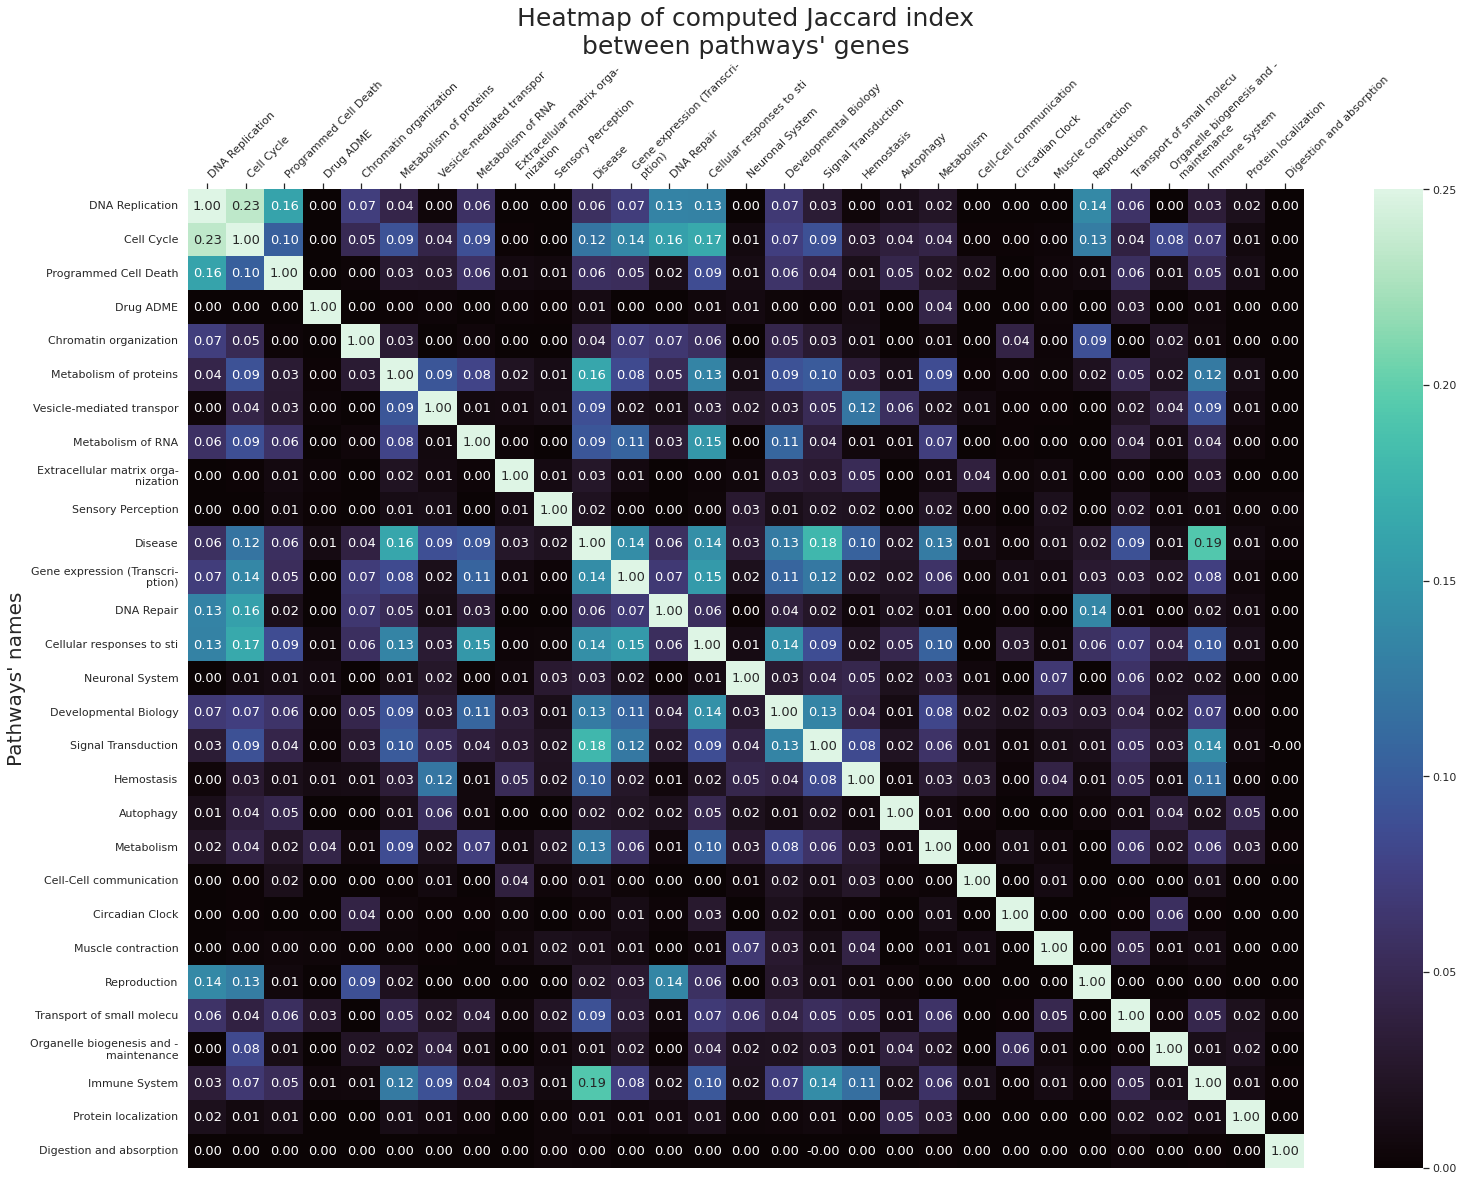

In [213]:
# Create heatmap object
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(figsize = (25,18))
heatmap = sns.heatmap(final_df, annot = True, annot_kws={'size': 13}, fmt=".2f", vmin=0, vmax=0.25, cmap="mako")
heatmap.set_xticklabels(heatmap.get_xticklabels())
plt.xticks(rotation=45, horizontalalignment='left')
heatmap.set_ylabel("Pathways' names", size=20)
heatmap.set_title("Heatmap of computed Jaccard index\nbetween pathways' genes", size = 25)